In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


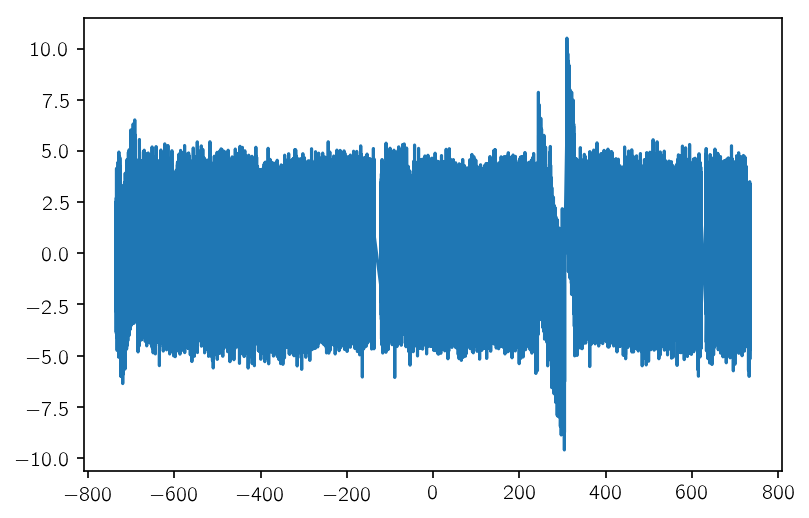

In [60]:
# kicid = 4253860
kicid = 9837267

data = np.loadtxt("kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)
nu_arr = metadata[::6][:1]

plt.plot(times, dmmags);

In [61]:
sess = tf.InteractiveSession()

In [62]:
T = tf.float32

porb_tensor = tf.placeholder(T)
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)
nu_tensor = tf.placeholder(T, nu_arr.shape)

tp_tensor = tf.Variable(0.0, dtype=T)
# ad_tensor = tf.placeholder(T)
# ad_tensor = tf.Variable(0.01, dtype=T)

mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
C = 2.0 * np.pi * nu_tensor[None, :] * tf.sin(mean_anom)[:, None]
C2 = tf.square(C)
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * times_tensor[:, None]
cos = tf.cos(arg_tensor)
sin = tf.sin(arg_tensor)

D_tensor = tf.concat([
    sin,
    -C2 * sin,
    -C * sin,
    C * cos,
    cos,
    -C2 * cos,
], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor))
# chi2_tensor -= tf.linalg.logdet(DTD_tensor)
# grad_tensor = tf.gradients(chi2_tensor, tp_tensor)

# A = W_hat_tensor[0]
a1 = W_hat_tensor[3] / W_hat_tensor[0]
a2 = W_hat_tensor[2] / W_hat_tensor[4]

# opt = tf.train.GradientDescentOptimizer(1.0).minimize(chi2_tensor, var_list=[tp_tensor])
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, [tp_tensor], method="L-BFGS-B")

In [69]:
init = tf.global_variables_initializer()
sess.run(init)
data = {times_tensor: times, dmmags_tensor: dmmags, porb_tensor: 100.0, nu_tensor: nu_arr}

In [70]:
print(sess.run(chi2_tensor, feed_dict=data))
print(sess.run([a1, a2], feed_dict=data))

64046.4
[array([  1.11360769e-05], dtype=float32), array([ -7.87324279e-06], dtype=float32)]


In [73]:
periods = np.exp(np.linspace(np.log(50), np.log(500), 150))
chi2s = np.empty((len(periods), 2))
a1s = np.empty_like(chi2s)
a2s = np.empty_like(chi2s)
for i, period in enumerate(periods):
    data[porb_tensor] = period
    opt.minimize(sess, feed_dict=data)
    chi2s[i, 0], a1s[i, 0], a2s[i, 0] = sess.run([chi2_tensor, a1, a2], feed_dict=data)
    
    tf.assign_add(tp_tensor, 0.5 * period)
    opt.minimize(sess, feed_dict=data)
    chi2s[i, 1], a1s[i, 1], a2s[i, 1] = sess.run([chi2_tensor, a1, a2], feed_dict=data)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.207031
  Number of iterations: 2
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.207031
  Number of iterations: 1
  Number of functions evaluations: 12
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64046.097656
  Number of iterations: 4
  Number of functions evaluations: 76
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64046.128906
  Number of iterations: 0
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64046.152344
  Number of iterations: 1
  Number of functions ev

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.101562
  Number of iterations: 2
  Number of functions evaluations: 16
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.101562
  Number of iterations: 1
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64046.589844
  Number of iterations: 0
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64046.589844
  Number of iterations: 0
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64046.394531
  Number of iterations: 4
  Number of functions ev

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.550781
  Number of iterations: 2
  Number of functions evaluations: 19
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.550781
  Number of iterations: 1
  Number of functions evaluations: 11
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.464844
  Number of iterations: 3
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.464844
  Number of iterations: 1
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.320312

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64043.964844
  Number of iterations: 3
  Number of functions evaluations: 15
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64043.945312
  Number of iterations: 2
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64045.003906
  Number of iterations: 4
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64044.992188
  Number of iterations: 2
  Number of functions evaluations: 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64045.539062

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.542969
  Number of iterations: 4
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.542969
  Number of iterations: 1
  Number of functions evaluations: 15
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.535156
  Number of iterations: 3
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.535156
  Number of iterations: 1
  Number of functions evaluations: 16
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.628906

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64045.863281
  Number of iterations: 4
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64045.906250
  Number of iterations: 0
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 64045.496094
  Number of iterations: 4
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 64045.496094
  Number of iterations: 0
  Number of functions evaluations: 1
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64045.171875
  Number of iterations: 2
  Number of functions ev

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64046.808594
  Number of iterations: 1
  Number of functions evaluations: 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64043.757812
  Number of iterations: 3
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64043.757812
  Number of iterations: 0
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64042.183594
  Number of iterations: 1
  Number of functions evaluations: 17
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64042.183594
  Number of itera

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64039.562500
  Number of iterations: 0
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64041.058594
  Number of iterations: 4
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 64040.917969
  Number of iterations: 1
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64042.300781
  Number of iterations: 4
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 64042.300781
  Number of iterations: 1
  Numbe

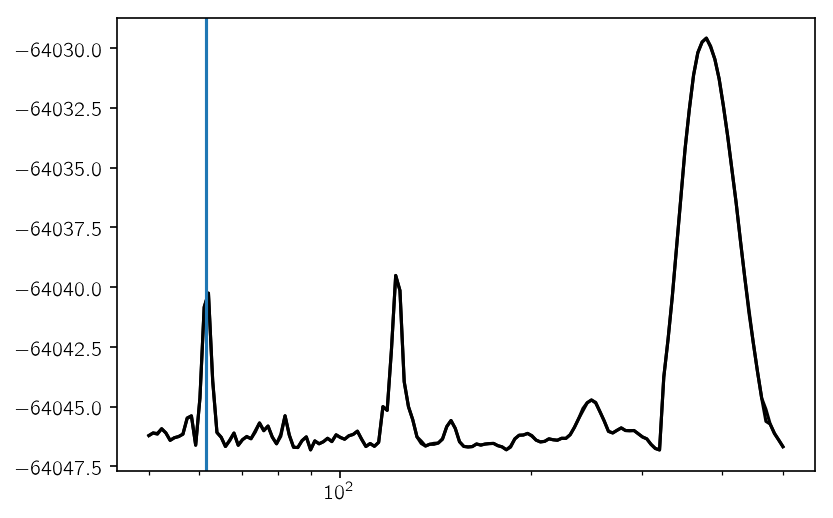

In [74]:
plt.semilogx(periods, -chi2s, "k")
plt.axvline(61.580743)

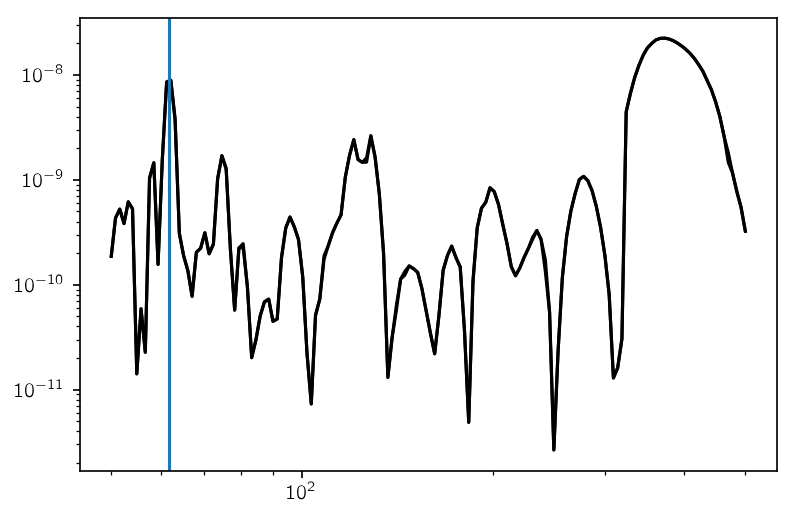

In [75]:
plt.loglog(periods, a1s**2 + a2s**2, "k")
plt.axvline(61.580743)

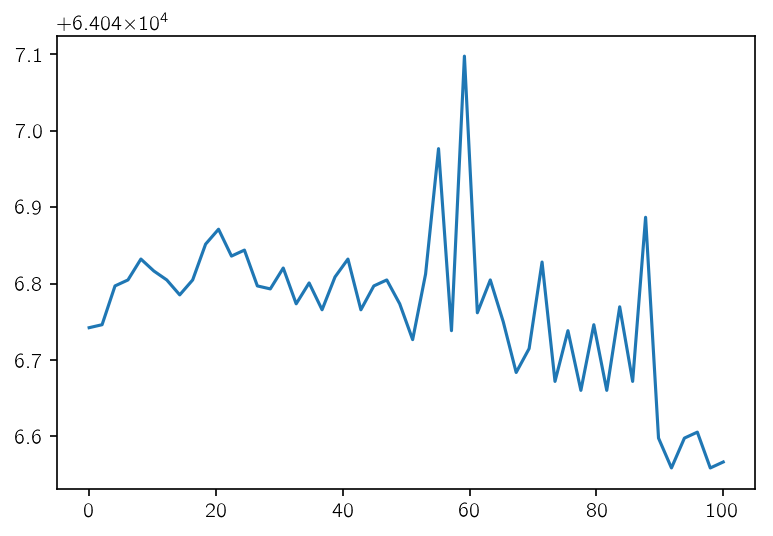

In [68]:
t0s = np.linspace(0, 100, 50).astype(np.float32)
chi2s = np.empty_like(t0s)
for i, t0 in enumerate(t0s):
    data[tp_tensor] = t0
    chi2s[i] = sess.run(chi2_tensor, feed_dict=data)
plt.plot(t0s, chi2s)

In [77]:
%timeit np.median(dmmags)

1000 loops, best of 3: 430 µs per loop
